**Universidade de São Paulo**

**Programa de Educação Continuada - Escola Politécnica**

**Gláucio Soares da Silva  - Nº USP: 15031246**

**Monografia Especialização em Inteligência Artificial**

**TEMA: Aplicação de Redes Neurais Recorrentes em Séries Temporais para Gestão de Recursos Hídricos na Região Metropolitana de São Paulo**

O objetivo deste trabalho é desenvolver e avaliar um modelo preditivo para o volume útil dos reservatórios do Sistema Cantareira, com foco na Represa Jaguari/Jacareí. O modelo utiliza redes neurais recorrentes LSTM (Long Short-Term Memory), muito utilizada para modelar séries temporais.

1 - IMPORTAÇÃO DAS BIBLIOTECAS

Esse código carrega as bibliotecas para manipulação de dados (pandas, numpy), pré-processamento (MinMaxScaler), redes neurais (tensorflow e keras), e visualização (matplotlib).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from dataclasses import dataclass

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2



2 - CONFIGURAÇÃO DO EXPERIMENTO

Esta célula centraliza todos os hiperparâmetros do experimento em uma estrutura única. Essa abordagem facilita ajustes, garante rastreabilidade das configurações e favorece a reprodutibilidade científica.

In [3]:
# Definir semente para garantir reprodutibilidade
SEED = 42
tf.keras.utils.set_random_seed(SEED)


In [4]:
@dataclass
class Config:
    csv_path: Path = Path("bd_sistema_cantareira.csv")
    represa: str = "Represa Jaguari/Jacareí"

    target_col: str = "Volume (%)*"
    feature_cols: list[str] = None

    window_size: int = 180
    model_horizon: int = 90
    total_horizon: int = 720
    test_ratio: float = 0.2

    batch_size: int = 64
    max_epochs: int = 300
    dropout: float = 0.3
    l2: float = 1e-4
    learning_rate: float = 1e-3
    early_stop: int = 20

cfg = Config()
cfg.n_blocks = cfg.total_horizon // cfg.model_horizon


3 - LEITURA E ORGANIZAÇÃO DOS DADOS

Esta célula realiza a leitura do arquivo CSV contendo os dados históricos do Sistema Cantareira. Em seguida, os dados são filtrados para o reservatório de interesse e ordenados cronologicamente.

In [5]:
df = pd.read_csv(cfg.csv_path, sep=";", decimal=",", encoding="utf-8-sig")
df = df[df["Represa"] == cfg.represa].copy()

df["Data"] = pd.to_datetime(df["Data"])
df = df.sort_values("Data").reset_index(drop=True)



/tmp/ipython-input-1672429748.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Data"] = pd.to_datetime(df["Data"])


 4 - SELEÇÃO DAS VARIÁVEIS

 Nesta etapa, define-se a variável de entrada e a variável alvo do modelo. O experimento é conduzido de forma univariada, utilizando apenas o volume percentual do reservatório, permitindo avaliar a capacidade do modelo em aprender padrões temporais a partir do histórico disponível.

In [6]:
feature_cols = [cfg.target_col] if cfg.feature_cols is None else cfg.feature_cols

X = df[feature_cols].values
y = df[[cfg.target_col]].values


5 - NORMALIZAÇÃO DOS DADOS

Os dados são normalizados para o intervalo [-1, 1], prática recomendada para redes neurais recorrentes. A normalização contribui para maior estabilidade numérica durante o treinamento e acelera a convergência do modelo.

In [7]:
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)


5 - CRIAÇÃO DO DATASET COM JANELAS TEMPORAIS

Esta célula transforma a série temporal em um conjunto supervisionado, utilizando janelas deslizantes. Cada amostra contém 180 dias de histórico como entrada e 90 dias futuros como saída, viabilizando a previsão multi-step.

In [8]:
def create_windowed_dataset(X, y, window_size, horizon):
    Xs, ys = [], []
    for i in range(len(X) - window_size - horizon + 1):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size:i+window_size+horizon].flatten())
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_windowed_dataset(
    X_scaled, y_scaled, cfg.window_size, cfg.model_horizon
)


6 - DIVISÃO TREINO / TESTE

A divisão entre treino e teste respeita a ordem temporal da série, garantindo que o modelo seja avaliado apenas em dados futuros. Não há embaralhamento das amostras, preservando a causalidade temporal.

In [9]:
split_idx = int(len(X_seq) * (1 - cfg.test_ratio))

X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]


7 - DEFINIÇÃO DO MODELO LSTM

Aqui é definida a arquitetura da rede neural recorrente. Duas camadas LSTM empilhadas permitem capturar dependências temporais de médio prazo. As camadas Dropout e a regularização L2 reduzem o risco de overfitting. A camada de saída prevê 90 dias futuros.

In [10]:
model = Sequential([
    LSTM(128, return_sequences=True, kernel_regularizer=l2(cfg.l2),
         input_shape=(cfg.window_size, X_train.shape[2])),
    Dropout(cfg.dropout),

    LSTM(64, return_sequences=False, kernel_regularizer=l2(cfg.l2)),
    Dropout(cfg.dropout),

    Dense(64, activation="relu"),
    Dense(cfg.model_horizon)
])

model.compile(
    optimizer=Adam(cfg.learning_rate),
    loss="mse"
)

print("Estrutura do Modelo LSTM:")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Estrutura do Modelo LSTM:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 180, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 180, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90)             │         5,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,978 (492.10 KB)

 Trainable params: 125,978 (492.10 KB)

 Non-trainable params: 0 (0.00 B)

8 - TREINAMENTO DO MODELO

Esta célula executa o treinamento do modelo. O Early Stopping interrompe o treinamento quando não há melhoria na perda de validação, evitando sobreajuste e reduzindo o custo computacional.

In [11]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=cfg.early_stop,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=cfg.max_epochs,
    batch_size=cfg.batch_size,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/300
92/92 - 50s - 543ms/step - loss: 0.0973 - val_loss: 0.0202
Epoch 2/300
92/92 - 45s - 493ms/step - loss: 0.0334 - val_loss: 0.0149
Epoch 3/300
92/92 - 81s - 884ms/step - loss: 0.0292 - val_loss: 0.0157
Epoch 4/300
92/92 - 83s - 904ms/step - loss: 0.0263 - val_loss: 0.0157
Epoch 5/300
92/92 - 82s - 892ms/step - loss: 0.0252 - val_loss: 0.0135
Epoch 6/300
92/92 - 45s - 490ms/step - loss: 0.0237 - val_loss: 0.0151
Epoch 7/300
92/92 - 46s - 504ms/step - loss: 0.0229 - val_loss: 0.0127
Epoch 8/300
92/92 - 47s - 510ms/step - loss: 0.0216 - val_loss: 0.0132
Epoch 9/300
92/92 - 45s - 493ms/step - loss: 0.0217 - val_loss: 0.0120
Epoch 10/300
92/92 - 82s - 891ms/step - loss: 0.0206 - val_loss: 0.0122
Epoch 11/300
92/92 - 46s - 501ms/step - loss: 0.0207 - val_loss: 0.0114
Epoch 12/300
92/92 - 81s - 878ms/step - loss: 0.0195 - val_loss: 0.0112
Epoch 13/300
92/92 - 46s - 500ms/step - loss: 0.0193 - val_loss: 0.0097
Epoch 14/300
92/92 - 46s - 504ms/step - loss: 0.0184 - val_loss: 0.0121
E

9 - GRÁFICO DA FUNÇÃO DE PERDA

Esse código apresenta a função de perda durante o treinamento e conforme o erro vai diminuindo conforme o número de épocas.

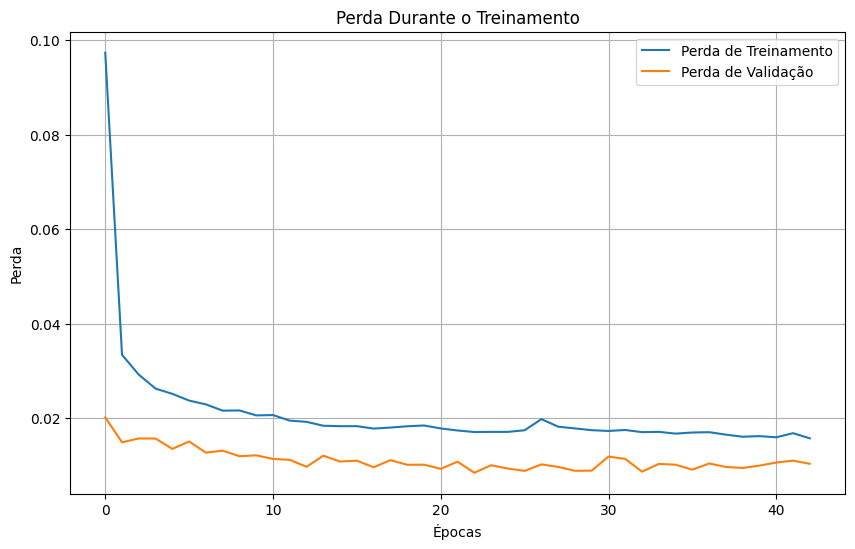

In [12]:
# Plotando o gráfico de perda durante o treinamento
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda Durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)
plt.show()



10 - PREVISÃO EM BLOCOS (720 DIAS)

Esta função implementa a estratégia de previsão em blocos. O modelo gera previsões de 90 dias, que são utilizadas iterativamente como entrada para os blocos seguintes, até atingir o horizonte total de 720 dias.

In [13]:
def forecast_in_blocks(model, last_window, n_blocks, block_size):
    forecasts = []
    current_window = last_window.copy()

    for _ in range(n_blocks):
        pred_block = model.predict(
            current_window.reshape(1, *current_window.shape),
            verbose=0
        )[0]

        forecasts.extend(pred_block)

        for p in pred_block:
            new_row = current_window[-1].copy()
            new_row[0] = p
            current_window = np.vstack([current_window[1:], new_row])

    return np.array(forecasts)


11 - AVALIAÇÃO NO CONJUNTO DE TESTE

Os valores previstos e reais são retornados à escala original, possibilitando interpretação direta das métricas e comparação visual com os dados observados.

In [14]:
y_test_pred_scaled = model.predict(X_test)

y_test_pred = scaler_y.inverse_transform(
    y_test_pred_scaled.reshape(-1, 1)
).reshape(y_test.shape)

y_test_real = scaler_y.inverse_transform(
    y_test.reshape(-1, 1)
).reshape(y_test.shape)


58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step


12 - MÉTRICAS DE AVALIAÇÃO

In [15]:
y_test_pred_scaled = model.predict(X_test)

y_test_pred = scaler_y.inverse_transform(
    y_test_pred_scaled.reshape(-1, 1)
).reshape(y_test.shape)

y_test_real = scaler_y.inverse_transform(
    y_test.reshape(-1, 1)
).reshape(y_test.shape)


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step


In [16]:
rmse_30 = np.sqrt(
    mean_squared_error(
        y_test_real[:, :30].flatten(),
        y_test_pred[:, :30].flatten()
    )
)

rmse_90 = np.sqrt(
    mean_squared_error(
        y_test_real.flatten(),
        y_test_pred.flatten()
    )
)

print(f"RMSE (30 dias): {rmse_30:.2f}")
print(f"RMSE (90 dias): {rmse_90:.2f}")


RMSE (30 dias): 3.07
RMSE (90 dias): 6.64


13 - GRÁFICO DO MSE POR HORIZONTE

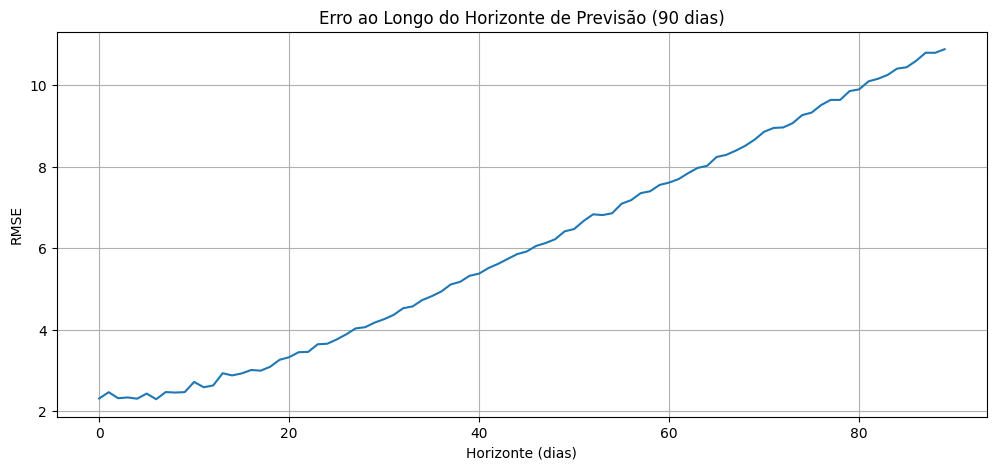

In [17]:
rmse_per_horizon = [
    np.sqrt(mean_squared_error(y_test_real[:, h], y_test_pred[:, h]))
    for h in range(cfg.model_horizon)
]

plt.figure(figsize=(12,5))
plt.plot(rmse_per_horizon)
plt.xlabel("Horizonte (dias)")
plt.ylabel("RMSE")
plt.title("Erro ao Longo do Horizonte de Previsão (90 dias)")
plt.grid(True)
plt.show()


14 - GRÁFICO REAL × PREVISTO (CURTO PRAZO)

O gráfico compara os valores reais e previstos para o horizonte de um dia à frente, validando visualmente o desempenho do modelo em curto prazo.

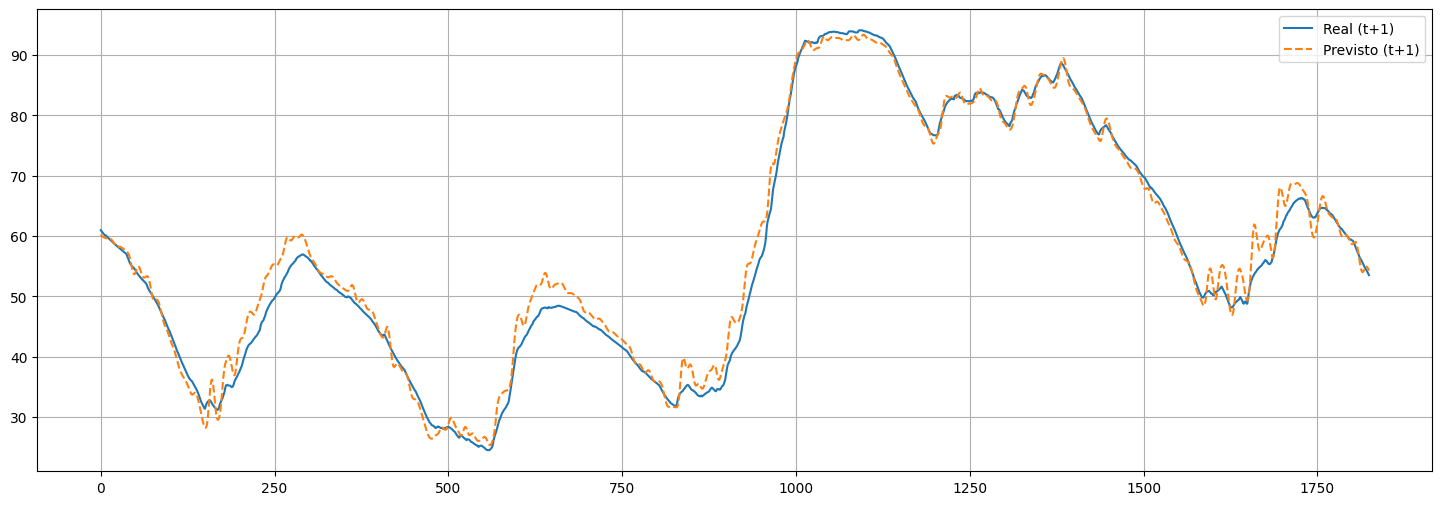

In [18]:
plt.figure(figsize=(18,6))
plt.plot(y_test_real[:, 0], label="Real (t+1)")
plt.plot(y_test_pred[:, 0], '--', label="Previsto (t+1)")
plt.legend()
plt.grid(True)
plt.show()


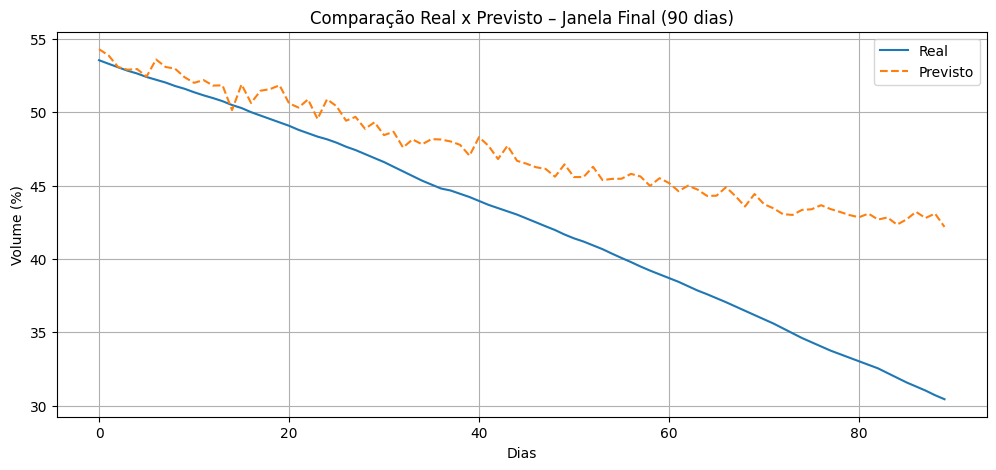

In [19]:
# Última janela do conjunto de teste

last_idx = -1
h = 90  # horizonte máximo previsto pelo modelo

real_last_window = y_test_real[last_idx, :h]
pred_last_window = y_test_pred[last_idx, :h]

plt.figure(figsize=(12,5))
plt.plot(real_last_window, label="Real")
plt.plot(pred_last_window, '--', label="Previsto")
plt.xlabel("Dias")
plt.ylabel("Volume (%)")
plt.title("Comparação Real x Previsto – Janela Final (90 dias)")
plt.legend()
plt.grid(True)
plt.show()


Real window shape: (180,)
Pred window shape: (180,)


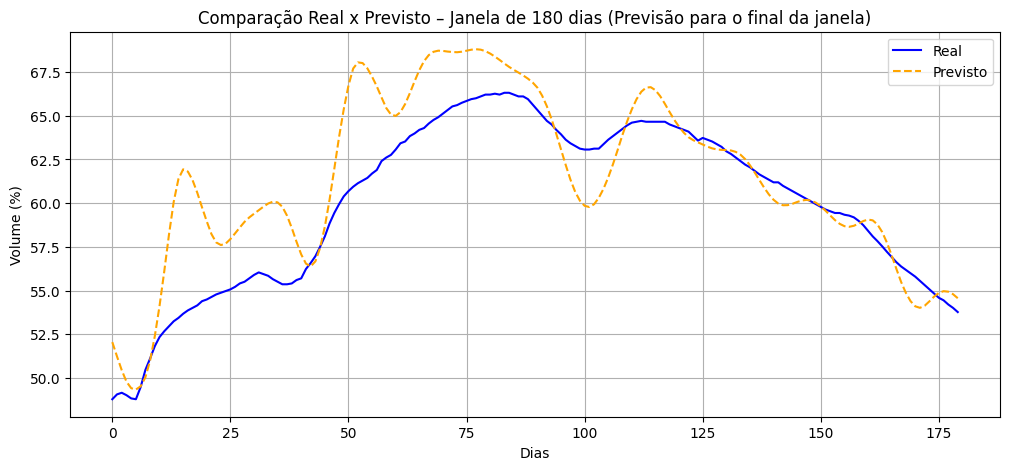

In [25]:
# Ajustando para a janela de 180 dias de dados reais e previsão para essa mesma janela
real_window = y_test_real[last_idx - window_size:last_idx, 0]  # Últimos 180 dias reais
pred_window = y_test_pred[last_idx - window_size:last_idx, 0]  # Previsão para os 180 dias (final da janela)

# Verificando as formas dos dados
print("Real window shape:", real_window.shape)
print("Pred window shape:", pred_window.shape)

# Plotando a comparação Real x Previsto para a mesma janela
plt.figure(figsize=(12, 5))

# Plotando os dados reais (últimos 180 dias observados)
plt.plot(range(window_size), real_window, label="Real", color='blue')

# Plotando a previsão (para os 180 dias seguintes)
plt.plot(range(window_size), pred_window, '--', label="Previsto", color='orange')


plt.xlabel("Dias")
plt.ylabel("Volume (%)")
plt.title("Comparação Real x Previsto – Janela de 180 dias (Previsão para o final da janela)")
plt.legend()
plt.grid(True)
plt.show()


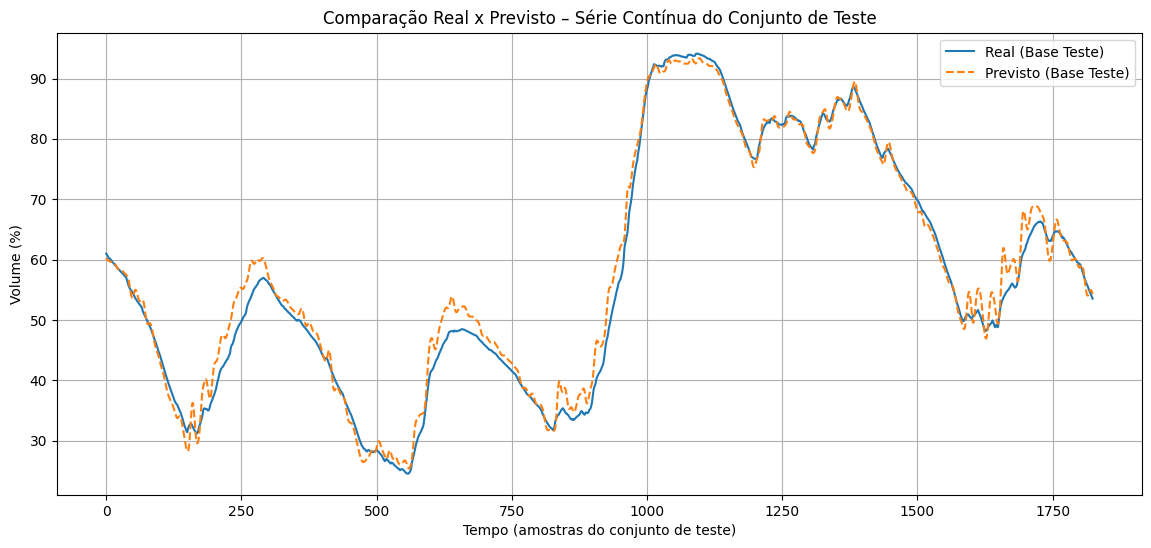

In [26]:
# Real x Previsto Base Teste

real_series_test = y_test_real[:, 0]
pred_series_test = y_test_pred[:, 0]

plt.figure(figsize=(14,6))
plt.plot(real_series_test, label="Real (Base Teste)")
plt.plot(pred_series_test, '--', label="Previsto (Base Teste)")
plt.xlabel("Tempo (amostras do conjunto de teste)")
plt.ylabel("Volume (%)")
plt.title("Comparação Real x Previsto – Série Contínua do Conjunto de Teste")
plt.legend()
plt.grid(True)
plt.show()


15 - SÉRIE HISTÓRICA × PREVISÃO (720 DIAS)

Este gráfico apresenta a série histórica completa e a projeção de longo prazo gerada pelo modelo, permitindo análise visual da tendência prevista e da suavização inerente ao horizonte estendido.

In [27]:
def forecast_in_blocks(model, last_window, n_blocks, block_size):
    forecasts = []
    current_window = last_window.copy()

    for _ in range(n_blocks):
        pred_block = model.predict(
            current_window.reshape(
                1,
                current_window.shape[0],
                current_window.shape[1]
            ),
            verbose=0
        )[0]

        forecasts.extend(pred_block)

        for p in pred_block:
            new_row = current_window[-1].copy()
            new_row[0] = p
            current_window = np.vstack([current_window[1:], new_row])

    return np.array(forecasts)


In [28]:
last_window = X_scaled[-cfg.window_size:]

forecast_scaled = forecast_in_blocks(
    model,
    last_window,
    cfg.n_blocks,
    cfg.model_horizon
)

forecast = scaler_y.inverse_transform(
    forecast_scaled.reshape(-1, 1)
).flatten()


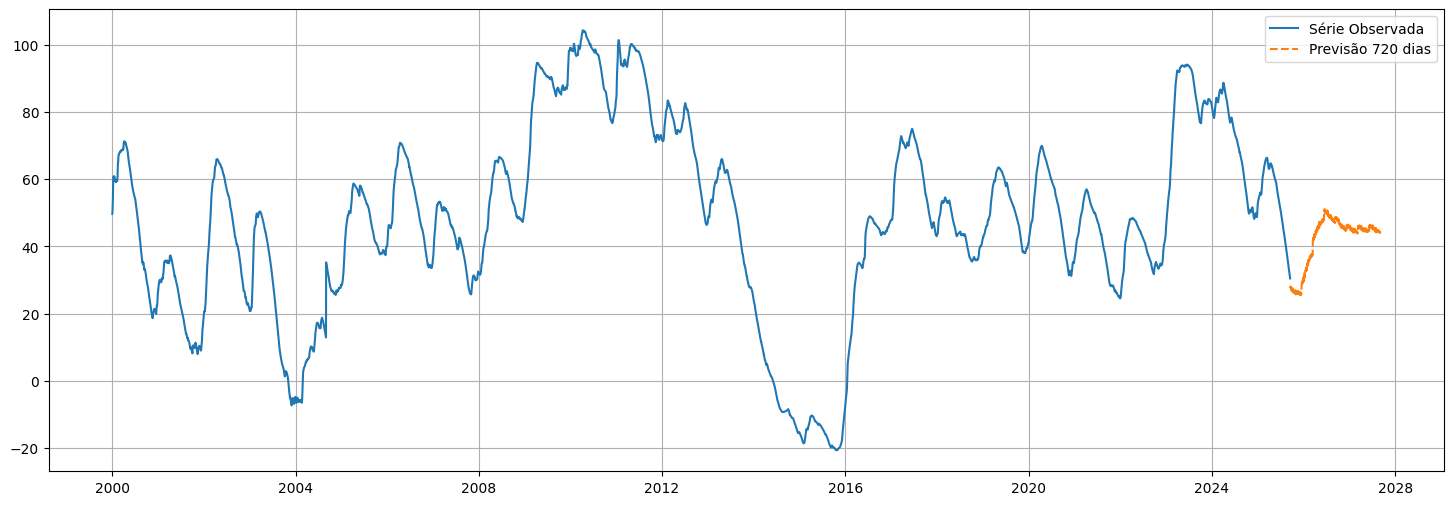

In [29]:
future_dates = pd.date_range(
    start=df["Data"].iloc[-1] + pd.Timedelta(days=1),
    periods=cfg.total_horizon
)

plt.figure(figsize=(18,6))
plt.plot(df["Data"], df[cfg.target_col], label="Série Observada")
plt.plot(future_dates, forecast, '--', label="Previsão 720 dias")
plt.legend()
plt.grid(True)
plt.show()


**Conclusão**

Redes LSTM previram com sucesso o volume do reservatório Jaguari/Jacareí, com alta aderência em horizontes imediatos. A estratégia multi-step (blocos de 90 dias) para projeções de até 720 dias superou a previsão direta, garantindo maior estabilidade e menor propagação de erros.



